## Importing headers

In [115]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

______________

## Data Loading and Exploration

In [117]:
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01")
df

C:\Users\rk\AppData\Local\Temp\ipykernel_19524\101187372.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620850,72.681296,71.373226,71.627100,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146935,72.753816,71.926907,72.497522,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200
...,...,...,...,...,...
2025-07-29,211.270004,214.809998,210.820007,214.179993,51411700
2025-07-30,209.050003,212.389999,207.720001,211.899994,45512500


<Axes: xlabel='Date'>

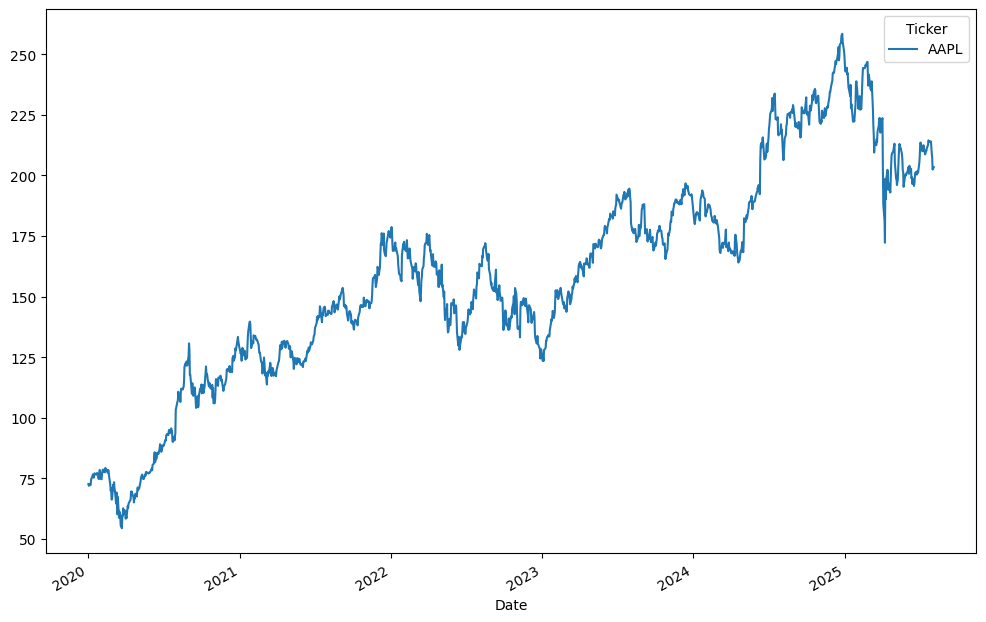

In [118]:
df.Close.plot(figsize=(12,8))

In [119]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [120]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.930649
2020-01-03,-1.946509
2020-01-06,-1.933637
2020-01-07,-1.941295
2020-01-08,-1.915225
...,...
2025-07-29,1.183796
2025-07-30,1.133929
2025-07-31,1.100684


In [121]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])    # Each sequence overlaps with the previous one by 29 elements.

data = np.array(data)

For now we are only splitting into sets of 30 with `overlap`.  
So that later is if input X is 1-29 then y is 30, the next set will be input X --> 2-30 and y --> 31  

  

![](./image.png)  
  
  The arrow shows y value value

In [122]:
print(data)   # now in sets of 30

[[[-1.93064932]
  [-1.94650876]
  [-1.93363677]
  ...
  [-1.82192509]
  [-1.78060377]
  [-1.79328878]]

 [[-1.94650876]
  [-1.93363677]
  [-1.94129477]
  ...
  [-1.78060377]
  [-1.79328878]
  [-1.79285314]]

 [[-1.93363677]
  [-1.94129477]
  [-1.91522484]
  ...
  [-1.79328878]
  [-1.79285314]
  [-1.8252457 ]]

 ...

 [[ 0.83270276]
  [ 0.85381783]
  [ 0.95310327]
  ...
  [ 1.24624262]
  [ 1.18379612]
  [ 1.13392872]]

 [[ 0.85381783]
  [ 0.95310327]
  [ 0.96433466]
  ...
  [ 1.18379612]
  [ 1.13392872]
  [ 1.1006839 ]]

 [[ 0.95310327]
  [ 0.96433466]
  [ 0.93737939]
  ...
  [ 1.13392872]
  [ 1.1006839 ]
  [ 0.98410202]]]


In [123]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device) # first 29 elements in all sequences
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)  # last element ie 30th element

X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)  # only diff is no :train_size but starts from train_size:
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

##### Slice Explanation: `data[:train_size, :-1, :]`

- `:train_size` → First `train_size` samples (batches)
- `:-1`        → All time steps **except the last one**
- `:`          → All features

In [124]:
print("data.shape:", data.shape)  # (total_samples, sequence_length=30, num_features=1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

data.shape: (1374, 30, 1)
X_train shape: torch.Size([1099, 29, 1])
y_train shape: torch.Size([1099, 1])
X_test shape: torch.Size([275, 29, 1])
y_test shape: torch.Size([275, 1])


#### Why We Don't Shuffle Time Series Data

Unlike regular machine learning tasks (e.g., classification with `train_test_split(shuffle=True)`), time series data has a **temporal order**.

Shuffling the data would break the sequence of events and **leak future information into the past**, making the model unrealistic and invalid for real-world prediction.

So we keep the **older data for training** and the **newer data for testing**, preserving the timeline and making the prediction task reflect real scenarios.


___________________

## Model Building and Training

In [125]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))  # Explained below
        out = self.fc(out[:, -1, :])  # [allsamples, last timestep, all features]

        return out

self.lstm(...) returns → (output, (hn, cn))  
So you must unpack like -- `out, (hn, cn) = ...`

In [126]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [127]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [128]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model (X_train)

    loss = criterion(y_train_pred, y_train)

    if i == 0 or (i + 1) % 25 == 0:
        print(i+1, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

1 0.6325476765632629
25 0.012487365864217281
50 0.006196457892656326
75 0.005327708553522825
100 0.00494709936901927
125 0.004628434311598539
150 0.004344177432358265
175 0.004098540637642145
200 0.0038967113941907883


## Model Evaluation

In [129]:
model.eval()

# with torch.no_grad():  --------- # either do this or detach later like below
#     y_test_pred = model(X_test)

y_test_pred = model(X_test)

# For regression tasks like this we need to inverse tranform and calculate the RMSE (for classification we would just calculate Accuracy where inverse is not needed)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [130]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
print(f"Train RMSE: {train_rmse}")

test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])
print(f"Test RMSE: {test_rmse}")

Train RMSE: 2.7789814472198486
Test RMSE: 5.252917766571045


# 

# Prediction and RMSE Visualization

To visualize Actual vs Predicted lets take  

`x-axis` --> `df.iloc[-len(y_test):].index` *Selects the last len(y_test) rows from the DataFrame df and extracts their index (typically date/time values)*  

`y-axis` --> `y_test`*(actual)* and `y_test_pred`*(predicted)* stock price  

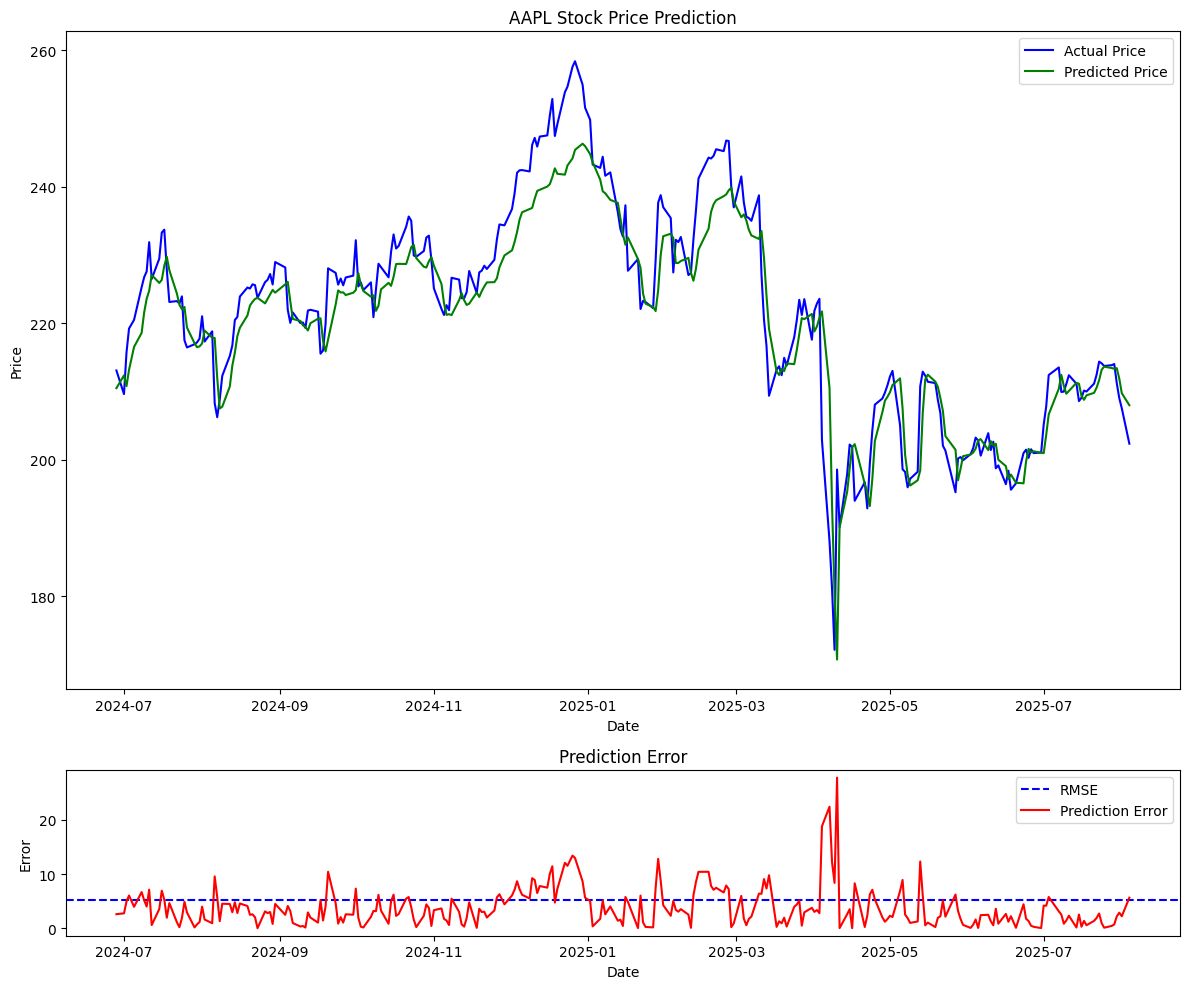

In [ ]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1)

# First subplot: Actual vs Predicted Prices
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')  # x-axis --> df.iloc[-len(y_test):].index
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')
ax1.legend()
ax1.set_title(f'{ticker} Stock Price Prediction')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Second subplot: Prediction Error
ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
ax2.set_title('Prediction Error')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error')  # <- corrected this line

plt.tight_layout()
plt.show()

___________